## Transcript class enrichment

In [1]:
import pybedtools 
import sys
import numpy as np
import pandas as pd
import os
import itertools
import math
import matplotlib.pyplot as plt
from itertools import chain
import matplotlib
import seaborn as sns; sns.set(color_codes=True)
from matplotlib.colors import LinearSegmentedColormap

sns.set_style("ticks")
%matplotlib inline

#### set parameters

In [2]:
home_dir = '/home/salma/Coding/scratch' 

pipeline_dir = os.path.join(home_dir, 'pipeline_not_unique')
plotting_dir = os.path.join(home_dir, 'plots/enrichment_analysis')
analysis_dir = os.path.join(home_dir, 'data_analysis')

all_yeast = pybedtools.BedTool(os.path.join(home_dir, 'Annotations/saccharomyces_cerevisiae.gff')).remove_invalid().saveas()

pathways_of_interest = ['Deadenylation', 'Decapping', 'Xrn1', 'Exosome', 'TRAMP', 'Ski',  'NMD']
colors = ['r', 'g', 'xkcd:orange', '#0000FF', '#1E90FF', '#87CEEB', '#C2BC87']

In [3]:
def featuretype_filter(feature, featuretype):
    if feature[2] == featuretype:
        return True
    return False


def subset_featuretypes(featuretype):
    result = all_yeast.filter(featuretype_filter, featuretype).remove_invalid().sort().saveas()
    return pybedtools.BedTool(result.fn)


def count_reads_in_features(features_fn):
    return y_bed.intersect(features_fn,
                         bed =True).count()


#### combine all annotations and resolve overlaps

In [4]:
#read UTRs
utr3  = pybedtools.BedTool(os.path.join(home_dir,'Annotations/yeast_from_bjoern/threeprime_UTR.bed'))
utr5  = pybedtools.BedTool(os.path.join(home_dir,'Annotations/yeast_from_bjoern/fiveprime_UTR.bed'))

#ncRNA classes from Bjoen's annotations
#the rest comes from the gtf file annotation of yeast

nc_anno_file = os.path.join(home_dir, "Annotations/yeast_from_bjoern/cerevisiae.feature.anno.txt")
nc_yeast_annotations = pd.read_table(nc_anno_file, sep='\t', index_col = 0)
nc_yeast_annotations = nc_yeast_annotations[['chr','start', 'end', 'type', 'name','strand','commonName', 'source']]

nc_yeast_annotations.to_csv(os.path.splitext(nc_anno_file)[0] +'.bed',
               index=None, sep = '\t', header = False)

#ncRNA classes from CUT SUT NUT datasets published before
#the rest comes from the gtf file annotation of yeast

nc_anno_file = os.path.join(home_dir, "Annotations/yeast_from_bjoern/cerevisiae.feature.anno.txt")
nc_yeast_annotations = pd.read_table(nc_anno_file, sep='\t', index_col = 0)
nc_yeast_annotations = nc_yeast_annotations[['chr','start', 'end', 'type', 'name','strand','commonName', 'source']]

nc_yeast_annotations.to_csv(os.path.splitext(nc_anno_file)[0] +'.bed',
               index=None, sep = '\t', header = False)

nc_yeast_pybed = pybedtools.BedTool(os.path.splitext(nc_anno_file)[0] +'.bed')

CUTs_df = nc_yeast_annotations.loc[nc_yeast_annotations.type.str.contains("CUT")]
NUTs_df = nc_yeast_annotations.loc[nc_yeast_annotations.type.str.contains("NUT")]
SUTs_df = nc_yeast_annotations.loc[nc_yeast_annotations.type.str.contains("SUT")]

CUTs_pybed = pybedtools.bedtool.BedTool.from_dataframe(CUTs_df).sort().merge(s = True, c = '5,6', o = 'distinct')
NUTs_pybed = pybedtools.bedtool.BedTool.from_dataframe(NUTs_df).sort().merge(s = True, c = '5,6', o = 'distinct')
SUTs_pybed = pybedtools.bedtool.BedTool.from_dataframe(SUTs_df).sort().merge(s = True, c = '5,6', o = 'distinct')

CUTs = CUTs_pybed.subtract(NUTs_pybed, s = True, A = True).subtract(SUTs_pybed, s = True, A = True)
NUTs = NUTs_pybed.subtract(CUTs_pybed, s = True, A = True).subtract(SUTs_pybed, s = True, A = True)
SUTs = SUTs_pybed.subtract(CUTs_pybed, s = True, A = True).subtract(NUTs_pybed, s = True, A = True)

#load different types based on feature names in the annotation

feature_names = ['CDS', 'intron', 'tRNA_gene','rRNA_gene', 'snoRNA_gene', 'snRNA_gene']

CDs, intron, tRNAs, rRNAs, snoRNAs, snRNAs = map(subset_featuretypes, feature_names)


#merge overlapping annotations within a feature
CDs = CDs.merge(s=True, c='6,7', o = 'distinct')
intron = intron.merge(s=True, c='6,7', o = 'distinct')
tRNAs = tRNAs.merge(s=True, c='6,7', o = 'distinct')
rRNAs = rRNAs.merge(s=True, c='6,7', o = 'distinct')
snoRNAs = snoRNAs.merge(s=True, c='6,7', o = 'distinct')
snRNAs = snRNAs.merge(s=True, c='6,7', o = 'distinct')

#makes sure there is no overlap between annotated features
#feature order: rRNA > tRNA > snRNA > snoRNA > intron > CDs > UTR3, UTR5 > SUTs, CUTs, NUTs

mRNAs = CDs.cat(intron, postmerge = False)

tRNAs = tRNAs.subtract(rRNAs, s = True, A = True)
snRNAs = snRNAs.subtract(rRNAs, s = True, A = True).subtract(tRNAs, s = True, A = True)
snoRNAs = snoRNAs.subtract(rRNAs, s = True, A = True).subtract(tRNAs, s = True, A = True).subtract(snRNAs, s = True, A = True)
intron = intron.subtract(rRNAs, s = True, A = True).subtract(tRNAs, s = True, A = True).subtract(snRNAs, s = True, A = True).subtract(snoRNAs, s = True, A = True)
CDs = CDs.subtract(rRNAs, s = True, A = True).subtract(tRNAs, s = True, A = True).subtract(snRNAs, s = True, A = True).subtract(snoRNAs, s = True, A = True).subtract(intron,
    s = True, A = True)
utr3 = utr3.subtract(rRNAs, s = True, A = True).subtract(tRNAs, s = True, A = True).subtract(snRNAs, s = True, A = True).subtract(snoRNAs, s = True, A = True).subtract(mRNAs,
    s = True, A = True)
utr5 = utr5.subtract(rRNAs, s = True, A = True).subtract(tRNAs, s = True, A = True).subtract(snRNAs, s = True, A = True).subtract(snoRNAs, s = True, A = True).subtract(mRNAs,
    s = True, A = True).subtract(utr3, s = True, A = True)  
SUTs = SUTs.subtract(rRNAs, s = True, A = True).subtract(tRNAs, s = True, A = True).subtract(snRNAs, s = True, A = True).subtract(snoRNAs, s = True, A = True).subtract(mRNAs,
    s = True, A = True).subtract(utr3, s = True, A = True).subtract(utr5, s = True, A = True)
CUTs = CUTs.subtract(rRNAs, s = True, A = True).subtract(tRNAs, s = True, A = True).subtract(snRNAs, s = True, A = True).subtract(snoRNAs, s = True, A = True).subtract(mRNAs,
    s = True, A = True).subtract(utr3, s = True, A = True).subtract(utr5, s = True, A = True)
NUTs = NUTs.subtract(rRNAs, s = True, A = True).subtract(tRNAs, s = True, A = True).subtract(snRNAs, s = True, A = True).subtract(snoRNAs, s = True, A = True).subtract(mRNAs,
    s = True, A = True).subtract(utr3, s = True, A = True).subtract(utr5, s = True, A = True)

features = (utr5, CDs, intron, utr3, rRNAs, tRNAs, snoRNAs, snRNAs, SUTs, CUTs, NUTs)
feature_names = ['UTR5', 'CDS', 'intron', 'UTR3', 'rRNA', 'tRNA', 'snoRNA', 'snRNA', 'SUTs', 'CUTs', 'NUTs']

In [5]:
# make a bed file containing all transcripts and save it for future use

nc_features = CUTs.cat(NUTs,SUTs, postmerge=False)
other_features = CDs.cat(intron, tRNAs, rRNAs, snoRNAs, snRNAs, postmerge=False)
utrs = utr5.cat(utr3, postmerge = False)

nc_features.saveas(os.path.join(home_dir, "Annotations/salma/ncRNA_all.bed"))
other_features.saveas(os.path.join(home_dir, "Annotations/salma/rest_features.bed"))
utrs.saveas(os.path.join(home_dir, "Annotations/salma/UTRs.bed"))

nc = pd.read_table( os.path.join(home_dir, "Annotations/salma/ncRNA_all.bed"),
                   sep='\t', header=None)[[0,1,2,4,5,5,5]]
rest = pd.read_table( os.path.join(home_dir, "Annotations/salma/rest_features.bed"),
                     sep='\t', header=None)[[0,1,2,4,5,5,5]]
utr = pd.read_table( os.path.join(home_dir, "Annotations/salma/UTRs.bed"),
                     sep='\t', header=None)[[0,1,2,3,5,5,5]]

nc.columns = ['chr','start', 'end','type','c1','c2', 'strand']
rest.columns = ['chr','start', 'end','type','c1','c2', 'strand']
utr.columns = ['chr','start', 'end','type','c1','c2', 'strand']

t = [['CUTs']*CUTs.count(), ['NUTs']*NUTs.count(), ['SUTs']*SUTs.count()]
t = list(chain.from_iterable(t))
nc.type = t

#rest.type = rest.type.replace('mRNA', 'CDS')

frames = [nc, rest]
#frames = [nc, rest, utr]
all_features = pd.concat(frames)
all_features.index = range(len(all_features))
all_features.to_csv(os.path.join(home_dir, "Annotations/salma/all_features.bed"), 
                    index=None, sep = '\t', header = False)

#### calculate enrichment based on .table files generated by mockinbird preprocessing pipeline

In [6]:
#this function counts different annotation types on a .table file produced by mockinbird
#buffer_base: number of bases to the right and left of XL site
#crosslink_count=True --> counts number of cross-link sites per feature. False --> Number of reads per feature is counted.

def count_types(directory_table, features, buffer_base, crosslink_count=False):  
    
    #make a bed format out of .table entries
    qtable = pd.read_table( directory_table,sep='\t')
    qtable = qtable.rename(columns= {'seqid' : 'chrom'})
    qtable['start'] = np.maximum(qtable ['position'] - buffer_base , 0) 
    qtable['end'] = qtable ['position'] + buffer_base
    qtable = qtable[['chrom','start', 'end', 'transitions', 'coverage', 'strand']]


    xlsites = pybedtools.BedTool.from_dataframe(qtable)

    #note: f[4]: number of par-clip reads
    results = list()
    for feature in features:
        if crosslink_count:
            results.append(sum([1 for f in xlsites.intersect(feature,  s = True, wa = True)]))
        else:
            intersect = xlsites.intersect(feature,  s = True, wa = True)
            results.append(sum([int(xl[4]) for xl in intersect]))

    return results


In [7]:
#this function counts different annotation types on a be pre_table file produced by mockinbird
#buffer_base: number of bases to the right and left of XL site
#to see how many are not in any feature

def count_all_reads(directory_table, crosslink_count=False):  
    
    #make a bed format out of .table entries
    if crosslink_count:
        return len(pd.read_table( directory_table,sep='\t'))
    else:
        qtable = pd.read_table( directory_table,sep='\t')
        qtable = qtable.rename(columns= {'seqid' : 'chrom'})
        qtable['start'] = qtable['position']
        qtable['end'] = qtable['position']
        qtable = qtable[['chrom','start', 'end', 'transitions', 'coverage', 'strand']]

    return sum(qtable.coverage)


In [8]:
#load data list
filter_factors=True
data_summary = pd.read_table(os.path.join(home_dir, 'data_summary_detailed.txt'), header=None)

data_summary.columns=['factor', 'pathway', 'group']
data_summary.index = data_summary.factor

factors = data_summary.factor
groups = data_summary.group
pathways = data_summary.pathway
g_names = data_summary.pathway.unique()

if filter_factors:
    factors = data_summary.loc[data_summary.pathway.isin(pathways_of_interest), 'factor']
    groups = data_summary.loc[data_summary.pathway.isin(pathways_of_interest), 'group']
    pathways = data_summary.loc[data_summary.pathway.isin(pathways_of_interest), 'pathway']
    lut = dict(zip(pathways.unique(), colors))

In [9]:
XL_count = False

# Count results_all_factors and freq_all_factors dfs where for each factor, counts and frequencys are
# presented respectively

directories_table = [os.path.join(pipeline_dir , d, 'preprocess', d + '.table') 
               for d in factors]


results_all_factors = pd.DataFrame(columns = feature_names)
sum_reads = {}
for i , d in enumerate(directories_table):
    if os.path.isfile(d):
        results_all_factors.loc[factors[i]] = count_types(d, features, 0, crosslink_count=XL_count)
        sum_reads[factors[i]] = count_all_reads(d, crosslink_count=XL_count)
        

In [10]:
#put those that are in none of the features as 'others'
results_all_factors['others'] = pd.Series(sum_reads)-results_all_factors.sum(axis=1)

In [11]:
#add pseudo count = 1
freq_all_factors = (results_all_factors + 1).divide((results_all_factors + 1).sum(axis = 1), axis='index')
freq_all_factors.index = [s.split('-')[0] for s in freq_all_factors.index]

freq_all_factors = freq_all_factors.reindex(factors)

In [12]:
results_all_factors

,UTR5,CDS,intron,UTR3,rRNA,tRNA,snoRNA,snRNA,SUTs,CUTs,NUTs,others
Ccr4,525566,32471307,143107,1130784,5440545,406374,893955,332450,14150,13496,4358,1146381.0
Pop2,168817,9888968,4706,537560,3895861,175780,652160,147319,1669,1891,68,358372.0
Not1,159976,9532768,4140,454954,3628952,185013,579754,111272,2547,2096,88,297741.0
Caf40,143796,8213583,5562,509158,3575012,161705,440109,129099,1009,1134,45,278782.0
Pan2,192421,9882833,8164,477598,2838797,178603,669428,111905,2202,3845,148,322380.0
Pan3,38669,1248621,1137,91198,900012,76585,100327,24608,482,377,68,71223.0
Dcp2,442998,32826372,46896,1809649,4240437,204124,798113,176647,79259,20083,7069,1334525.0
Dcp1,128610,9437867,13398,572746,1470242,72018,295209,36583,13156,4765,614,313194.0
Edc2,333120,26011894,38941,1229307,5312169,250827,954347,253825,34837,12318,1844,885353.0
Edc3,230953,19562167,36439,1129074,1103344,54635,117029,17030,40675,11277,7628,716858.0


In [13]:
freqs = freq_all_factors.copy()
freqs['mRNA'] = freqs.UTR3 + freqs.UTR5 + freqs.intron + freqs.CDS
freqs = freqs.loc[:,['mRNA', 'rRNA', 'tRNA', 'snoRNA', 'snRNA', 'SUTs', 'CUTs', 'NUTs', 'others']]
freqs.to_csv(os.path.join(plotting_dir, 'freqs.txt'), sep='\t')

In [14]:
#reorder columns by interest: 
cols = ['UTR5', 'CDS', 'intron', 'UTR3', 'rRNA', 'tRNA', 'snoRNA', 'snRNA', 'SUTs', 'CUTs', 'NUTs']

#coloring by pathway
lut_p = dict(zip(pathways.unique(), colors))
pw_colors = [lut_p[x] for x in pathways]

### plotting

In [15]:
def coefficient_of_variation(array):
    mn = np.mean(array)
    sigma = np.sqrt(np.var(array))
    return(sigma/mn)

In [16]:
cv = freq_all_factors.apply(coefficient_of_variation, axis=0)[cols]

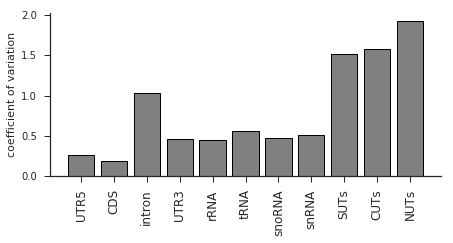

In [17]:
fig, ax = plt.subplots(figsize=(7,3))
sns.set_style("ticks")
ax.bar(np.arange(len(cv)), cv, color='grey', linewidth=1, edgecolor='black')
xt=plt.xticks(np.arange(len(cv)), cv.index, rotation=90, fontsize=12)
ax.set_ylabel('coefficient of variation')
sns.despine()
plt.savefig(os.path.join(plotting_dir, 'cv.pdf'), bbox_inches='tight')

### row and column wide normalization to get enrichment-like scores

In [18]:
def plot_enrichment(enrichment, colors, lut, attribute, colormap=matplotlib.cm.RdBu_r, filename='enrichment', saveplot=False, clustering=False, pathway=True, fig_size=(9,15), lw=0, sq=False):

    sns.set_style("ticks")
    g = sns.clustermap(enrichment, cmap=colormap, metric="correlation", robust=True, vmin=-2.5, vmax=2.5,
                       row_colors=colors, row_cluster=clustering, col_cluster = False,
                       figsize=fig_size, linewidth=lw, linecolor='black', rasterized = False, square=sq,
                       cbar_kws=dict(drawedges=False))
    
    g.ax_heatmap.xaxis.set_ticks_position('top')
    plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90, size=14)
    
    ax = g.ax_heatmap
    lines = np.append(0, np.cumsum([sum(data_summary.pathway==p) for p in pathways.unique()]))
    lineskw = dict(edgecolor='#15151c', linewidth=4)
    ax.hlines(lines, *ax.get_xlim(), **lineskw)
    ax.vlines([*ax.get_xlim()], *ax.get_ylim(), **lineskw)

    t = g.fig.suptitle("Enrichment of reads containing a verified transition over transcript classes")

    labels = attribute.unique() if pathway else np.sort(attribute.unique())
    for label in labels:
        g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                                label=label, linewidth=0)
        
    lgd = g.ax_col_dendrogram.legend(bbox_to_anchor=(1.25, 1), loc=2 )

    if(saveplot):
        plt.savefig(os.path.join(plotting_dir, filename+'.pdf'), bbox_extra_artists=(lgd,t,), bbox_inches='tight')
        #plt.savefig(os.path.join(plotting_dir, filename+'.png'), bbox_extra_artists=(lgd,t,), bbox_inches='tight')

In [19]:
#calculate row and column wide normalization

cols = ['UTR5', 'CDS', 'intron', 'UTR3', 'rRNA', 'tRNA', 'snoRNA', 'snRNA', 'SUTs', 'CUTs', 'NUTs']
x_fc = results_all_factors[cols]
x_fc.columns = ['5\' UTR', 'CDS', 'intron', '3\' UTR', 'rRNA', 'tRNA', 'snoRNA', 'snRNA', 'SUT',  'CUT', 'NUT']

x_fc = x_fc.applymap(np.log2)

x_f0 = x_fc.mean(axis=1)
x_0c = x_fc.mean(axis=0)
x_00 = x_fc.mean(axis=0).mean()

In [20]:
enrichment_APC = x_fc
for f in x_fc.index:
    for c in x_fc.columns:
        enrichment_APC.loc[f,c] = enrichment_APC.loc[f,c] - (x_f0[f]*x_0c[c]/x_00)

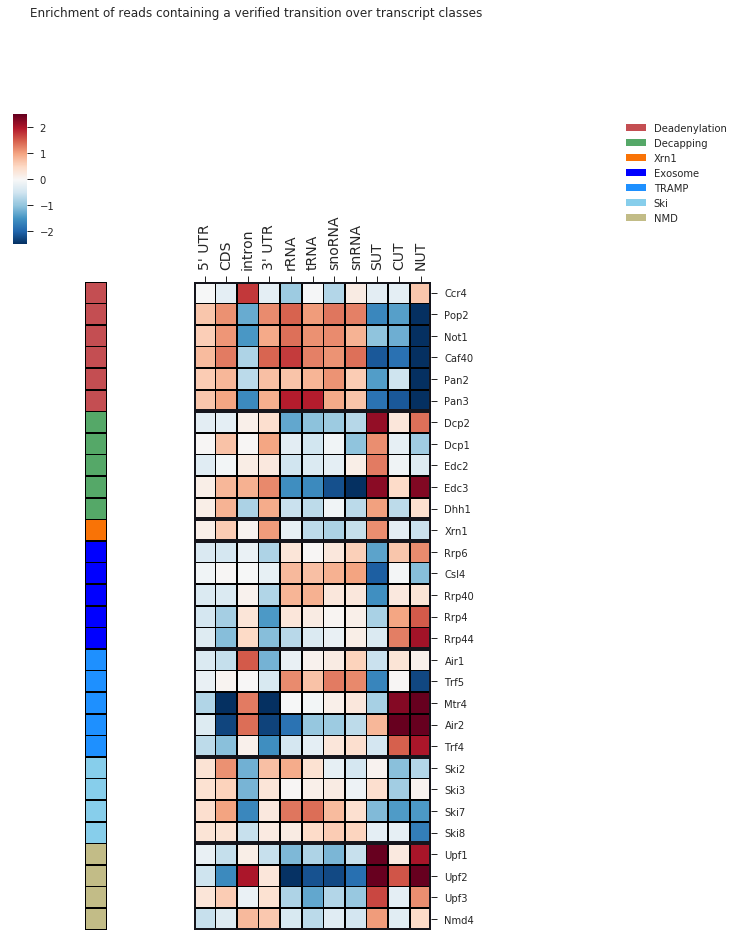

In [21]:
plot_enrichment(enrichment_APC, colormap=matplotlib.cm.RdBu_r, colors=pw_colors, lut=lut, attribute=pathways, 
                filename='enrichment_APC', saveplot=False, clustering=False, lw=0.5, sq=True)